# Projekt 1 - Inżynieria cech i wstępne modelowanie

## Załadowanie potrzebnych pakietów

In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Wczytanie i podział danych

In [87]:
chess_train = pd.read_csv('chess_train.csv')
chess_test = pd.read_csv('chess_test.csv')

In [88]:
y_train = chess_train['result']
X_train = chess_train.drop('result', axis = 1)
y_test = chess_test['result']
X_test = chess_test.drop('result', axis = 1)

## Wybór metryki

Problemem, jaki może się pojawić przy wyborze metryki jest fakt, że wartości kolumny *result* nie są binarne, lecz mamy aż 18 różnych możliwych wyników partii szachowej. Oczywiście, można by było przekształcić to w ten sposób, że chcemy analizować zwycięstwo białych figur lub jego brak (remis), jednak zależy nam by móc przewidywać także, po ilu ruchach to zwycięstwo nastąpi. Stąd dla klasyfikacji wieloklasowej rozważymy dwie metryki: **ROC AUC** oraz **F1 Score**. 

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

0.9759714402338433

In [49]:
y_pred = rf.predict(X_test)

In [51]:
y_test

0       14
1       15
2        9
3       12
4        8
        ..
8412     6
8413     5
8414    12
8415    14
8416     8
Name: result, Length: 8417, dtype: int64

In [50]:
y_pred

array([14, 15,  8, ..., 12, 14,  8], dtype=int64)

### ROC AUC Score

Żeby móc użyć **ROC AUC Score** dla klasyfikacji wieloklasowej, musi zostać ona przekształcona na binarną. Działa to w ten sposób, że najpierw jedna z klas uważana jest za pozytywną, reszta za negatywną, następnie inna jest pozytywna, reszta negatywna i tak 18 (w naszym przypadku) razy. Za każdym razem wyliczana jest pewna wartość współczynnika ovr (One vs Rest), a pod koniec liczona jest średnia ważona ze wszystkich wartości.

In [89]:
roc_auc_score(y_test, rf.predict_proba(X_test), average="weighted", multi_class="ovr")

0.9759714402338433

In [90]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization
    visualizer = ROCAUC(model, size=(1300, 860))
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

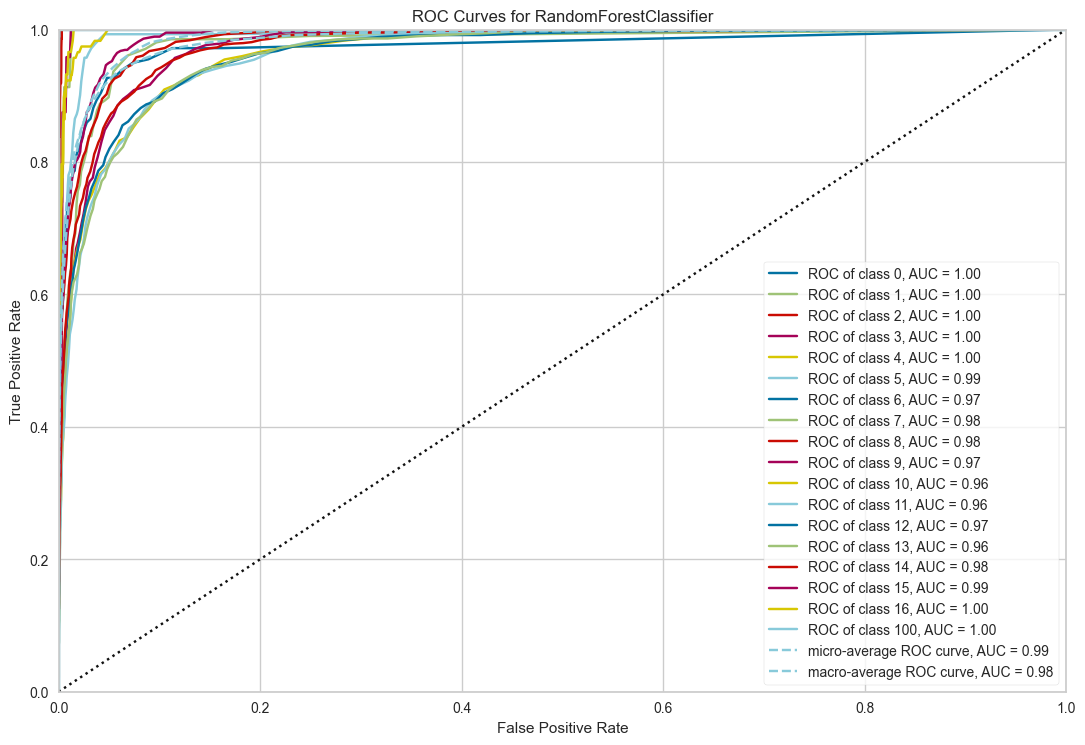

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=RandomForestClassifier())

In [26]:
plot_ROC_curve(rf, X_train, y_train, X_test, y_test)

### F1 Score

In [57]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9',
               'class 10', 'class 11', 'class 12', 'class 13', 'class 14', 'class 15', 'class 16', 'class 100']
print(classification_report(y_test, rf.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.62      0.77         8
     class 1       0.85      0.48      0.61        23
     class 2       0.80      0.96      0.87        74
     class 3       0.36      0.17      0.23        24
     class 4       0.72      0.64      0.68        59
     class 5       0.66      0.69      0.67       141
     class 6       0.73      0.60      0.66       178
     class 7       0.61      0.57      0.59       205
     class 8       0.74      0.75      0.74       430
     class 9       0.72      0.68      0.70       514
    class 10       0.74      0.64      0.69       596
    class 11       0.72      0.73      0.73       856
    class 12       0.76      0.76      0.76      1079
    class 13       0.76      0.76      0.76      1258
    class 14       0.77      0.87      0.82      1366
    class 15       0.79      0.79      0.79       650
    class 16       0.81      0.71      0.75       117
   class 100       1.00    

Wartość **F1 score** wyliczana jest na podstawie średniej harmonicznej wartośći **precision** (liczba prawdziwych pozytywnych wyników dzielona na liczbę wszystkich pozytywnych wyników, razem z tymi niepoprawnie zidentyfikowanymi) i **recall** (liczba wszystkich prawdziwych pozytywnych wyników dzielona na liczbę wszystkich wyników, które powinny być zidentyfikowane jako pozytywne) i zawiera się w przedziale od 0 do 1. Im wyższe F1, tym lepiej, bo oznacza to niską liczbę niepoprawnie zidentyfikowanych pozytywnych, jak i negatywnych wyników. 

### Wnioski

Model osiąga wręcz niebywałe wyniki w metryce ROC AUC. Według niej, predykcje są bezbłędne dla aż 7 klas wyników, a pozostałe są bliskie ideałowi. Patrząc na wyniki dla F1 wynik idelany uzyskujemy jedynie dla remisów, co nie jest zaskakujące ze względu na silną korelację rezultatu z kolumną wskazująca na atak czarnego króla - *black_king_attacking*. Niesamowicie słabo przewidywana jest sytuacja wygranej w 3 ruchach, natomiast pozostałe predykcje utrzymują wynik powyżej 0.5, a ogólne accuracy wynosi 0.77, co jest rozsądnym wynikiem.

## XGBoost

In [60]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[18:11:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [61]:
y_pred = xgb.predict(X_test)

### ROC AUC Score

In [64]:
roc_auc_score(y_test, xgb.predict_proba(X_test), average="weighted", multi_class="ovr")

0.9815366859997292

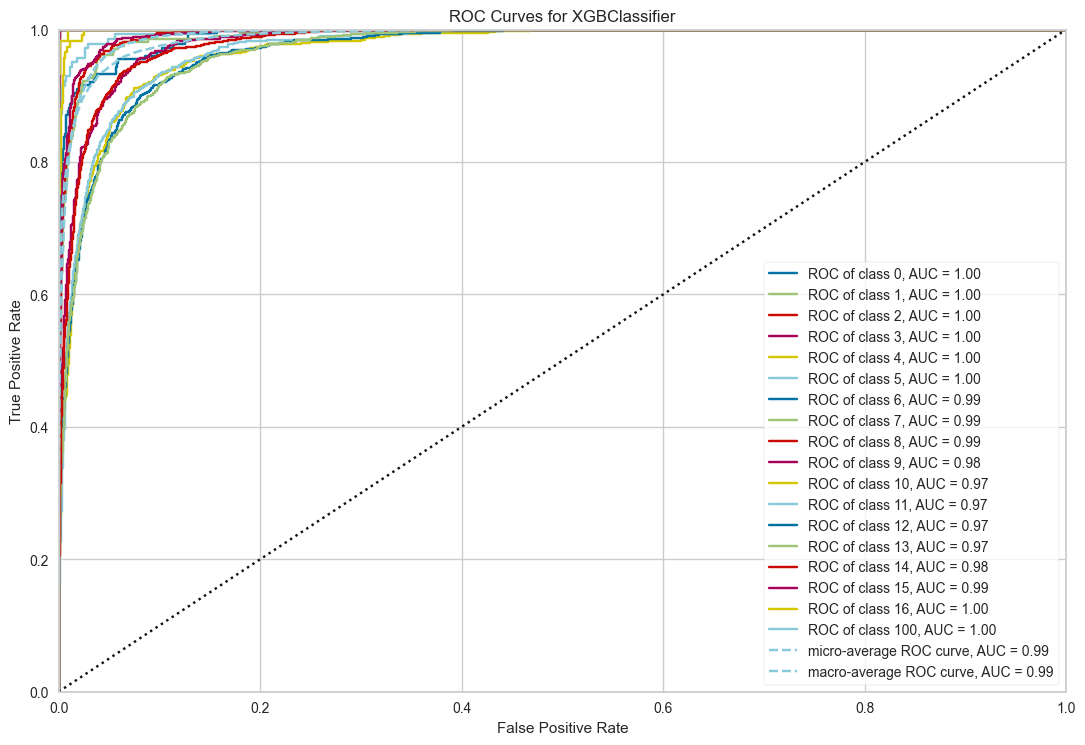

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
             

In [65]:
plot_ROC_curve(xgb, X_train, y_train, X_test, y_test)

### F1 Score

In [66]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9',
               'class 10', 'class 11', 'class 12', 'class 13', 'class 14', 'class 15', 'class 16', 'class 100']
print(classification_report(y_test, xgb.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.62      1.00      0.76         8
     class 1       0.95      0.91      0.93        23
     class 2       0.94      0.97      0.95        74
     class 3       0.87      0.83      0.85        24
     class 4       0.83      0.92      0.87        59
     class 5       0.87      0.88      0.88       141
     class 6       0.85      0.77      0.81       178
     class 7       0.75      0.72      0.74       205
     class 8       0.82      0.83      0.82       430
     class 9       0.77      0.71      0.74       514
    class 10       0.74      0.65      0.69       596
    class 11       0.75      0.76      0.75       856
    class 12       0.77      0.76      0.76      1079
    class 13       0.78      0.77      0.78      1258
    class 14       0.81      0.88      0.84      1366
    class 15       0.85      0.90      0.87       650
    class 16       0.86      0.79      0.82       117
   class 100       1.00    

### Wnioski
XGBoost również uzyskał niewiarygodnie wysokie wyniki w metryce ROCAUC - idealne wyniki uzuskało aż 8 klas, a dla pozostałych wartości nie zeszły poniżej 0.97. W metryce F1 ponownie idealny wynik uzyskał remis, a predykcja wygranej w 3 ruchach przedstawia się o wiele lepiej, ponieważ uzyskała wynik 0.85. Pozostałe wyniki są powyżej 0.7 oprócz najniższego wyniku - dla wygranej w 10 ruchach - który wyosi 0.69. Accuracy jest wysokie, lecz nie niepokojące: 0.81 uznajemy za rozsądny wynik.

## Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

### ROC AUC Score

In [68]:
roc_auc_score(y_test, lr.predict_proba(X_test), average="weighted", multi_class="ovr")

0.866521066426701

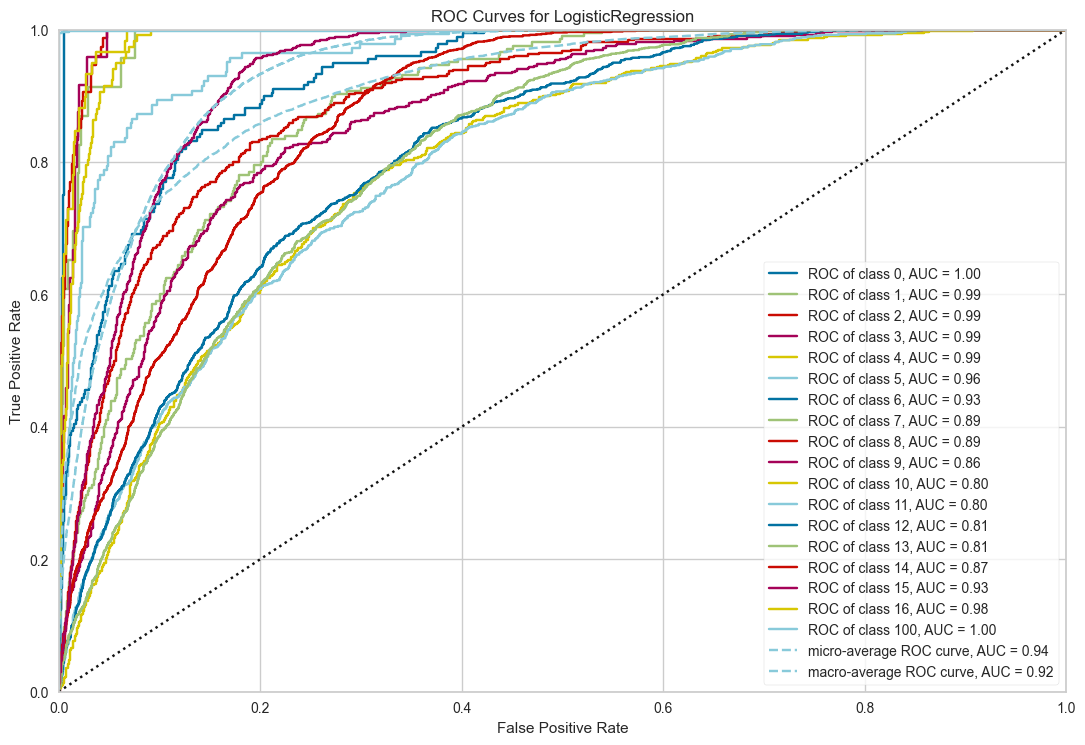

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=LogisticRegression(max_iter=1000))

In [69]:
plot_ROC_curve(lr, X_train, y_train, X_test, y_test)

### F1 Score

In [70]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9',
               'class 10', 'class 11', 'class 12', 'class 13', 'class 14', 'class 15', 'class 16', 'class 100']
print(classification_report(y_test, lr.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.33      0.12      0.18         8
     class 1       0.00      0.00      0.00        23
     class 2       0.45      0.68      0.54        74
     class 3       0.20      0.04      0.07        24
     class 4       0.54      0.42      0.48        59
     class 5       0.42      0.49      0.45       141
     class 6       0.39      0.34      0.37       178
     class 7       0.06      0.00      0.01       205
     class 8       0.34      0.53      0.41       430
     class 9       0.34      0.24      0.28       514
    class 10       0.22      0.12      0.16       596
    class 11       0.33      0.24      0.28       856
    class 12       0.36      0.43      0.39      1079
    class 13       0.39      0.40      0.39      1258
    class 14       0.44      0.61      0.51      1366
    class 15       0.47      0.42      0.45       650
    class 16       0.56      0.31      0.40       117
   class 100       1.00    

### Wnioski
Zastosowany model regresji logistycznej pomimo wysokich wyników (choć gorszych niż dla poprzednich modeli) ROC AUC, blado wybada w metryce F1. Różnica między wynikami jest wręcz szokująca - jedynie dla 3 klas wyniki wyniosły powyżej 0.5, a w najgorszym wypadku wyniosły 0. Co ciekawe, mimo tak niskich wyników, predykcyjność remisu utrzymała wysoki poziom z wynikiem 0.99. Podejrzewamy, że nie jest to dobry model dla rozpatrywanego zbioru.

## Decision Tree

In [76]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

### ROC AUC Score

In [77]:
roc_auc_score(y_test, dt.predict_proba(X_test), average="weighted", multi_class="ovr")

0.9174111059446841

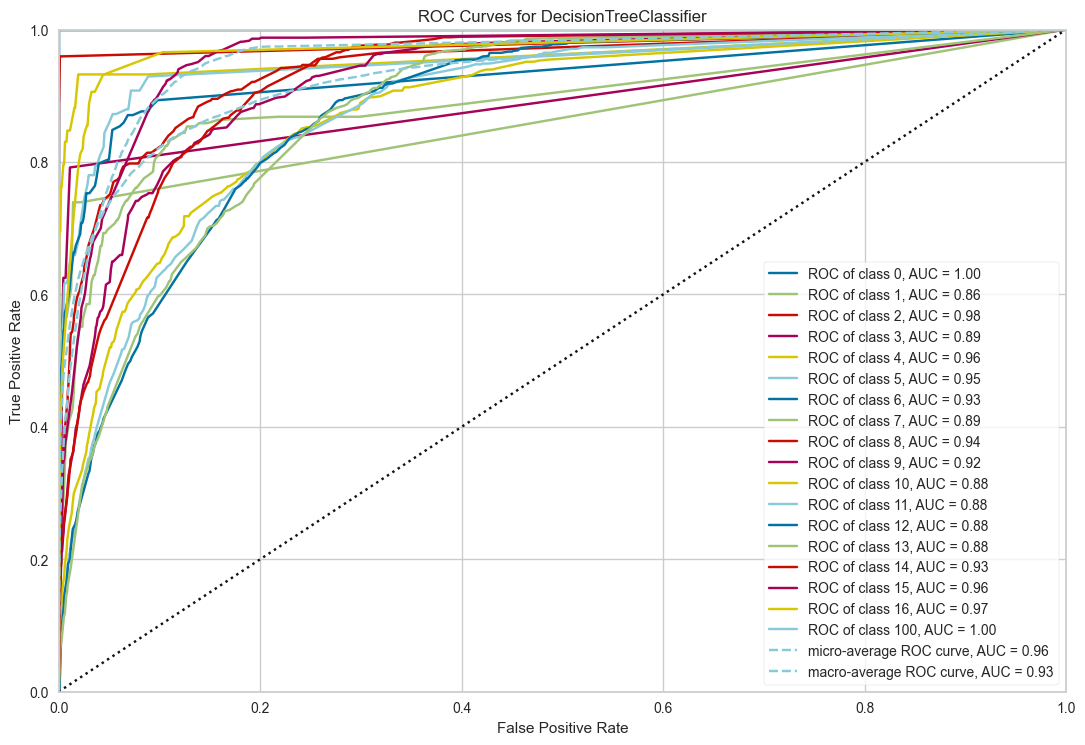

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=DecisionTreeClassifier(max_depth=10))

In [78]:
plot_ROC_curve(dt, X_train, y_train, X_test, y_test)

### F1 Score

In [79]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9',
               'class 10', 'class 11', 'class 12', 'class 13', 'class 14', 'class 15', 'class 16', 'class 100']
print(classification_report(y_test, dt.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00         8
     class 1       1.00      0.52      0.69        23
     class 2       0.86      0.89      0.87        74
     class 3       0.53      0.33      0.41        24
     class 4       0.70      0.76      0.73        59
     class 5       0.68      0.57      0.62       141
     class 6       0.72      0.49      0.58       178
     class 7       0.47      0.41      0.44       205
     class 8       0.68      0.55      0.61       430
     class 9       0.53      0.47      0.50       514
    class 10       0.49      0.40      0.44       596
    class 11       0.49      0.45      0.47       856
    class 12       0.53      0.45      0.48      1079
    class 13       0.49      0.62      0.55      1258
    class 14       0.60      0.73      0.66      1366
    class 15       0.61      0.63      0.62       650
    class 16       0.68      0.46      0.55       117
   class 100       1.00    

### Wnioski
Krzywe ROC AUC znów prezentują się wspaniale, lecz nie ma to odzwierciedlenia w metryce F1. Co ciekawe drzewo decyzyjne uzyskało idealne wyniki F1 nie tylko dla remisów, lecz także dla wygranej w 0 ruchach. Większość pozostałych wyników plasuje się pommiezy 0.4 a 0.7, natomiast wyniki nie schodzą poniżej 0.41. Accuracy wyniosło 0.6, nie jest to zły wynik, lecz oczekujemy od modelu nieco więcej.

## Gaussian Naive Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

### ROC AUC Score

In [81]:
roc_auc_score(y_test, gnb.predict_proba(X_test), average="weighted", multi_class="ovr")

0.7620196921688339

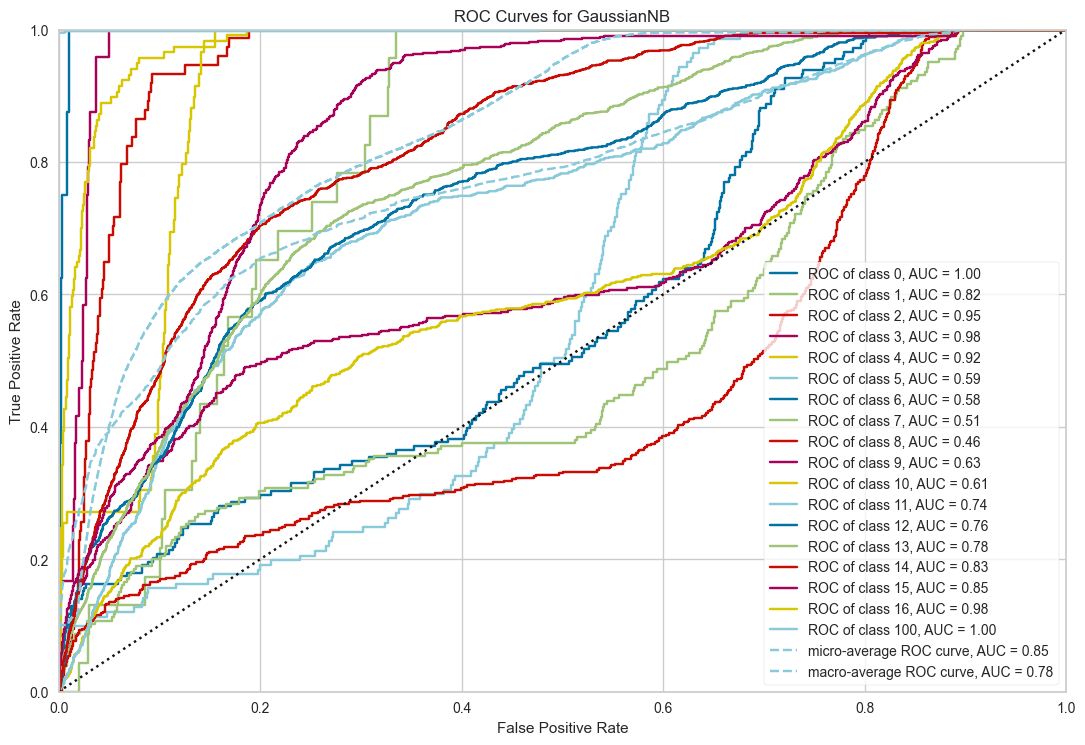

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GaussianNB())

In [82]:
plot_ROC_curve(gnb, X_train, y_train, X_test, y_test)

### F1 Score

In [83]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9',
               'class 10', 'class 11', 'class 12', 'class 13', 'class 14', 'class 15', 'class 16', 'class 100']
print(classification_report(y_test, gnb.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      1.00      0.01         8
     class 1       0.00      0.00      0.00        23
     class 2       0.00      0.00      0.00        74
     class 3       0.22      0.17      0.19        24
     class 4       0.20      0.24      0.22        59
     class 5       0.00      0.00      0.00       141
     class 6       0.06      0.01      0.02       178
     class 7       0.12      0.02      0.03       205
     class 8       0.21      0.04      0.07       430
     class 9       0.30      0.09      0.14       514
    class 10       0.00      0.00      0.00       596
    class 11       0.28      0.17      0.21       856
    class 12       0.40      0.26      0.31      1079
    class 13       0.36      0.52      0.42      1258
    class 14       0.49      0.38      0.42      1366
    class 15       0.56      0.11      0.18       650
    class 16       0.12      0.96      0.21       117
   class 100       1.00    

### Wnioski
Ostatni rozpatrywany model osiągnął zdecydowanie niższe wartości ROC AUC - co już nie wróżyło dobrze jego wydajności. Istotnie wyniki F1 okazały się fatalne - otrzymałyśmy niemal 5 zer, a pozostałe wartości nie wyszły ponad 0.42. Znów jednak została zachowana predykcyjność remisu z wynikiem 1. Model ten z pewnością nie nadaje się do naszego zbioru danych.

## Podsumowanie modeli

Wyzwaniem tego kamienia milowego okazał się dobór odpowiedniej metryki, ponieważ większość metryk jest przystosowanych dla binarnej zmiennej objaśnianej, podczas gdy w przypadku naszego modelu zmienna objaśniana przyjmuje aż 18 wartości. Zdecydowałyśmy się użyć 2 metryk w celu oceny stosowanych modeli: ROC AUC oraz F1. Należy zaznaczyć, że ROC AUC można stosować jedynie dla modeli, które posiadają wbudowaną metodę `predict_proba()` co zdeterminowało nasz wybór stosowanych modeli. Natomiast metryka F1 jest szczególnie atrakcyjna, ponieważ aby uzyskać w niej wysoki wynik, zarówno predykcje False Positive jak i False Negative muszą być nieliczne. Dla klasyfikacji wieloklasowej metryka F1 jest uznawana za lepszą od ROC AUC, jednakże dla celów dydaktycznych postanowiłyśmy przyjrzeć się obu.

Porównując wyniki uzyskane przez zastosowane modele stwierdzamy, że najlepiej wypada model drzewiasty XGBoost oraz Random Forest. W zalecanej metryce F1 uzyskały najlepsze wyniki, które jednocześnie nie są za bardzo bliskie ideałowi i nie sugerują przetrenowania modelu.

Model drzewa decyzyjnego nie był najgorszy, lecz jego wyniki nie były satysfakcjonujące - accuracy wyniosło 0.6. Na tle Random Forrest i XGBoost wypadł niekorzystnie. Gdyby spojrzeć na niego z perspektywy regresji logistycznej i naiwnego klasyfikatora bayesowskiego wypada już bardzo atrakcyjnie. Niskie accuracy czy pojawiające się wyniki 0 zdecydowanie wskazują na niedopasowanie modeli do danych.

Warto zaznaczyć, że wartośći ROC AUC dla wszystkich modeli okazały się wysokie - metryka F1 istotnie okazała się lepsza.
Co ciekawe, wszystkie modele znakomicie przewidywały remisy - podejrzewamy, że jest to wynik silnej korelacji rezultatu z kolumną wskazująca na atak czarnego króla - gdy czarny król atakuje wynikiem jest remis.
Podsumowując dla naszego zbioru danych lepsze okazują się być modele drzewiaste i to na nich powinnyśmy się skupić w przygotowywaniu finałowego modelu.
